# Import libraries

In [19]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import datasketch   
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from datasketch import MinHash, MinHashLSH
from tqdm import tqdm
from sklearn.model_selection import train_test_split

## Create a folder to store the figures.

In [20]:
fig_folder = "png"
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

## Import Dataset(The dataset after preprocessing)

In [21]:
print(os.getcwd())
path = os.path.abspath(os.path.join(os.getcwd(), "../data"))
print(path)
data = pd.read_csv(path + '/data_after_text_preprocessing.csv',index_col='id')

/Users/yusuke_sugihara/DA_Project1/DataAnalytics/Quora-question-pair-similarity
/Users/yusuke_sugihara/DA_Project1/DataAnalytics/data


# The techques that we used for this project are:
- Locality Sensitive Hashing (LSH)
- Machine Learning (ML)

We will investigate the results of both LSH and ML to see which has a better performance by comparing some indictors such precision and recall.

# Locality Sensitive Hashing (LSH)

In [22]:
X = data[['question1', 'question2']] # questions
y = data['is_duplicate'] # lable of the data (0 or 1)


### Due to the limitation of the computing power, we partially and randomly picked up samples for the LSH.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = X_train[:10000] # only use 100000 data for training randomly chosen
y_train = y_train[:10000] # only use 100000 data for training randomly chosen

In [24]:
print(X_train.head())
print(y_train.head())
print(X_train.shape)
print(y_train.shape)

                                                question1  \
id                                                          
140908  what is the new method of angioplasty which co...   
107096  on whatsapp  it says on the message info that ...   
27940   how do the holy scriptures of hinduism compare...   
157100  how long does it typically take to get a pilot...   
111382  my questions have not changed  why are they no...   

                                                question2  
id                                                         
140908           how much does it cost to run a hospital   
107096  my friend is abroad and i have sent him messag...  
27940   how do the holy scriptures of hinduism compare...  
157100  how much does it cost to get a private pilots ...  
111382  what should i do if my question is being marke...  
id
140908    0
107096    0
27940     0
157100    0
111382    1
Name: is_duplicate, dtype: int64
(10000, 2)
(10000,)


##  Create a dictionary

In [25]:
# combine the two questions into one list
com_data_train = X_train['question1'].append(X_train['question2']).reset_index()
print(com_data_train.head())

       id                                                  0
0  140908  what is the new method of angioplasty which co...
1  107096  on whatsapp  it says on the message info that ...
2   27940  how do the holy scriptures of hinduism compare...
3  157100  how long does it typically take to get a pilot...
4  111382  my questions have not changed  why are they no...


/var/folders/11/4w81_8697d9g_9c3944_ytwh0000gn/T/ipykernel_23675/1814244258.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  com_data_train = X_train['question1'].append(X_train['question2']).reset_index()


In [26]:
# drop the index column because it is not needed for creating the dictionary
com_data_train.drop(['id'],axis=1,inplace=True) 
com_data_train.columns = ['question'] # rename the column name
print(com_data_train.head())

                                            question
0  what is the new method of angioplasty which co...
1  on whatsapp  it says on the message info that ...
2  how do the holy scriptures of hinduism compare...
3  how long does it typically take to get a pilot...
4  my questions have not changed  why are they no...


In [27]:
print(com_data_train.shape) # check the shape of the combined data

(20000, 1)


In [28]:
# Create a dictory of all dupllcated questions.
correct = X_train
correct_dict = {}
for x,y in zip(correct['question1'],correct['question2']):
    if correct_dict.get(x)==None:
        correct_dict[x] = [y]
    else:
        correct_dict[x].append(y)
        correct_dict[x] = [i for i in set(correct_dict[x])]
for x,y in zip(correct['question2'],correct['question1']):
    if correct_dict.get(x)==None:
        correct_dict[x] = [y]
    else:
        correct_dict[x].append(y)
        correct_dict[x] = [i for i in set(correct_dict[x])]

## Set representation

In [29]:
set_dict={} # maps question to set representation of question
norm_dict={} # maps question id (eg 'm1') to actual question. We may use this dictionary to evaluate results of LSH output.
count=1

for question in tqdm([x for x in com_data_train['question'] if type(x)==str]):
    temp_list = []
    for shingle in question.split(' '): # shingle is a word
        if shingle not in stop_words:
            temp_list.append(shingle.lower())
    set_dict["m{}".format(count)] = set(temp_list)
    norm_dict["m{}".format(count)] = question
    count +=1

100%|██████████| 20000/20000 [00:00<00:00, 299882.32it/s]


In [30]:
set_dict['m1']

{'',
 '5k',
 'angioplasty',
 'blockage',
 'costs',
 'hospital',
 'j',
 'method',
 'mumbai',
 'new',
 'removal',
 'rs'}

In [31]:
norm_dict['m1']

'what is the new method of angioplasty which costs rs  5k   at j j hospital mumbai for removal of blockage '

## Minhashing

In [32]:
num_perm = 256 # number of permutations for MinHash
min_dict = {} # maps question to "min hash signatures"
count2 = 1
for val in tqdm (set_dict.values()): 
    m = MinHash(num_perm=num_perm) # create a MinHash object
    for shingle in val: 
        m.update(shingle.encode('utf8')) 
    min_dict["m{}".format(count2)] = m # add the minhash signature to the dictionary
    count2+=1
    
# print(min_dict['m1'].hashvalues)

100%|██████████| 20000/20000 [00:24<00:00, 825.95it/s]


## Localtiy Sensitive Hashing (LSH) phase

In [33]:
# find the candidates pairs in the training data
def create_cand_pairs(lsh):
    big_list = []
    for query in min_dict.keys():
        bucket = lsh.query(min_dict[query])
        if len(bucket)==1:
            big_list.append([bucket[0],"None"])
        if len(bucket)>1:
            first_val = bucket[0]
            for val in bucket[1:]:
                second_val = val
                big_list.append([first_val,second_val])
    return big_list

## Evaluation

In [34]:
def evaluation(cand_pairs):
    tp = 0 # true positive
    fp = 0 # false positive
    fn = 0 # false negative
    for pair in cand_pairs:
        if pair[1] == "None":
            if str(norm_dict[pair[0]]) in correct_dict.keys():
                    fn +=1
        else:
            if isinstance(correct_dict.get(norm_dict[pair[0]]), (list,)):
                if norm_dict[pair[1]] in correct_dict.get(norm_dict[pair[0]]):
                    tp +=1
                else:
                    fp +=1
                    
    precision = tp/(fp+tp)
    recall = tp/(fn+tp)
    print ('precision is {:.2f}'.format(precision))
    print ('recall is {:.2f}'.format(recall))
    return precision, recall

In [35]:
lsh_list = []
precision_list = []
recall_list = []

for i in range(2,10):
    lsh = MinHashLSH(threshold=i/10, num_perm=num_perm)
    lsh_list.append(lsh)

for lsh in tqdm(lsh_list):
    for key in tqdm(min_dict.keys()):
        lsh.insert(key,min_dict[key])
    precision, recall = evaluation(create_cand_pairs(lsh))
    
    precision_list.append(precision)
    recall_list.append(recall)

 12%|█▎        | 1/8 [00:25<02:58, 25.44s/it]

precision is 0.00
recall is 1.00


 25%|██▌       | 2/8 [00:31<01:24, 14.07s/it]

precision is 0.01
recall is 0.90


 38%|███▊      | 3/8 [00:36<00:48,  9.70s/it]

precision is 0.03
recall is 0.69


 50%|█████     | 4/8 [00:39<00:28,  7.15s/it]

precision is 0.07
recall is 0.54


 62%|██████▎   | 5/8 [00:42<00:16,  5.58s/it]

precision is 0.21
recall is 0.36


 75%|███████▌  | 6/8 [00:43<00:08,  4.12s/it]

precision is 0.28
recall is 0.25


 88%|████████▊ | 7/8 [00:44<00:03,  3.08s/it]

precision is 0.37
recall is 0.14


100%|██████████| 8/8 [00:44<00:00,  5.61s/it]

precision is 0.36
recall is 0.07


## Result of LSH (Precision and Recall)

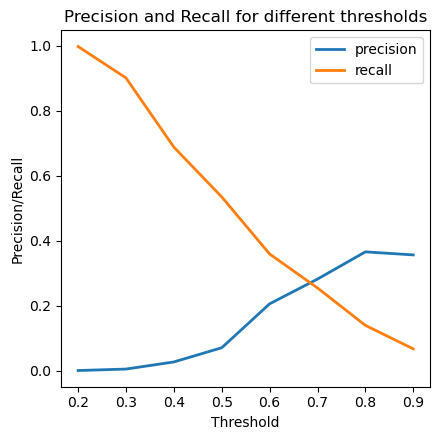

In [36]:
fig, ax = plt.subplots(figsize=(4.5,4.5))
plt.plot([i/10 for i in range(2,10)],precision_list, label='precision', linewidth=2)
plt.plot([i/10 for i in range(2,10)],recall_list, label='recall',linewidth=2)
plt.title("Precision and Recall for different thresholds")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'precision_recall.png'), dpi=450)
plt.show()